In [1]:
# import libraries and dependencies
import pandas as pd
import yfinance as yf
import plotly.graph_objects as go
import plotly.express as px
from pandas_datareader import data as pdr

# --STOCK DATA-- 
## Get SPY Data

In [2]:
# set ticker
ticker = "SPY"

# set timeframe for data
start = '2020-01-01'
end = '2021-01-01'

# pull historical stock data from 1/10/2005 to 3/8/2021
yf.pdr_override()
df_spy_historical_stock_data = pdr.get_data_yahoo(ticker, start=start, end=end)

# drop Dividends and Stock Split columns
df_spy_historical_stock_data = df_spy_historical_stock_data.drop(columns=['Adj Close']).reset_index()
df_spy_historical_stock_data.head()

[*********************100%***********************]  1 of 1 completed


Date        Open        High         Low       Close    Volume
0 2020-01-02  323.540009  324.890015  322.529999  324.869995  59151200
1 2020-01-03  321.160004  323.640015  321.100006  322.410004  77709700
2 2020-01-06  320.489990  323.730011  320.359985  323.640015  55653900
3 2020-01-07  323.019989  323.540009  322.239990  322.730011  40496400
4 2020-01-08  322.940002  325.779999  322.670013  324.450012  68296000

## Candlestick Chart - SPY

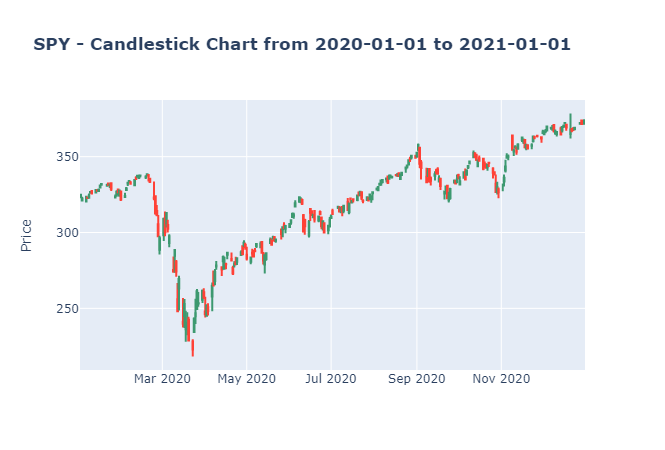

In [3]:
# plot SPY candlestick chart
spy_candlestick_chart = go.Figure(data=[go.Candlestick(x=df_spy_historical_stock_data['Date'],
                open=df_spy_historical_stock_data['Open'],
                high=df_spy_historical_stock_data['High'],
                low=df_spy_historical_stock_data['Low'],
                close=df_spy_historical_stock_data['Close'])])
spy_candlestick_chart.update_layout(
    title=f'<b>SPY - Candlestick Chart from {start} to {end}</b>',
    yaxis_title='Price',
    xaxis_rangeslider_visible=False)
spy_candlestick_chart.show()

## Closing Prices Line Chart - SPY

In [4]:
# slice historical stock data for closing prices
spy_close_prices = df_spy_historical_stock_data[['Date','Close']]

#rename close column to spy_close and set Date as index
spy_close_prices.rename(columns = {'Close':'spy_close'}, inplace = True)
spy_close_prices.set_index(keys = "Date" , inplace = True)
spy_close_prices.head()

C:\Users\avile\anaconda3\envs\pyvizenv\lib\site-packages\pandas\core\frame.py:4025: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



spy_close
Date                  
2020-01-02  324.869995
2020-01-03  322.410004
2020-01-06  323.640015
2020-01-07  322.730011
2020-01-08  324.450012

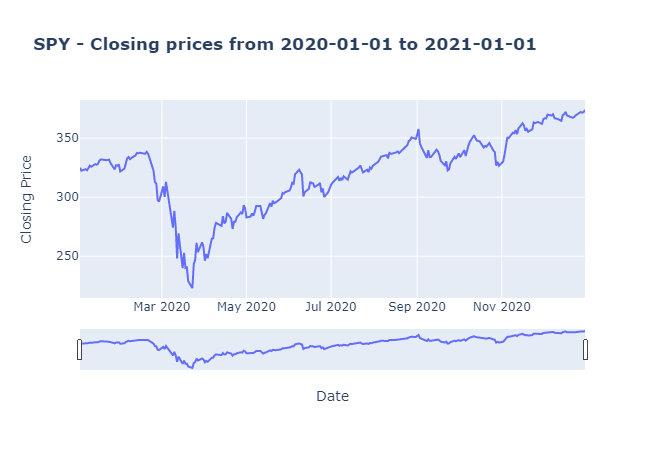

In [5]:
chart_spy_close_prices = px.line(spy_close_prices, y="spy_close", title=f'<b>SPY - Closing prices from {start} to {end}</b>')
chart_spy_close_prices.update_layout(yaxis_title='Closing Price',
                                     xaxis_rangeslider_visible=True)
chart_spy_close_prices.show()

# --OPTIONS DATA--
## Get SPY Options Data

In [6]:
# import historical options data
df_spy_historical_options_data = pd.read_csv('SPY_historical_options_data/SPY_2020.csv')

#remove rows where 'openinterest' equals zero and drop columns
df_spy_historical_options_data = df_spy_historical_options_data[df_spy_historical_options_data.openinterest != 0].reset_index(drop=True)
df_spy_historical_options_data = df_spy_historical_options_data.drop(columns=[' exchange','optionroot','optionext','impliedvol','delta','gamma',
                                                                              'theta','vega','optionalias','IVBid','IVAsk','bid','ask'])
df_spy_historical_options_data.rename(columns = {'expiration':'Date'}, inplace = True)
df_spy_historical_options_data['Date'] = pd.to_datetime(df_spy_historical_options_data['Date'])
# df_spy_historical_options_data['Date'] = df_spy_historical_options_data['Date'] - pd.Timedelta(1, unit='D')
df_spy_historical_options_data.set_index(keys = "Date" , inplace = True)

df_spy_historical_options_data.head()

underlying  underlying_last type   quotedate  strike  last  volume  \
Date                                                                            
2020-01-03        SPY           324.87  put  01/02/2020   260.0  0.00       0   
2020-01-03        SPY           324.87  put  01/02/2020   265.0  0.01       0   
2020-01-03        SPY           324.87  put  01/02/2020   270.0  0.01       0   
2020-01-03        SPY           324.87  put  01/02/2020   272.5  0.01       0   
2020-01-03        SPY           324.87  put  01/02/2020   275.0  0.01       0   

            openinterest  
Date                      
2020-01-03          4239  
2020-01-03         32850  
2020-01-03         47124  
2020-01-03          5649  
2020-01-03          1161

# --MERGE DATA--
## Merge stocks and options data

In [7]:
# merge stock data and options data
df_stocks_and_options = pd.merge(
    spy_close_prices,
    df_spy_historical_options_data,
    how="inner",
    on="Date",
    left_on=None,
    sort=True
)

df_stocks_and_options = df_stocks_and_options.reset_index()
df_stocks_and_options.rename(columns = {"Date":"expiration_date",
                                       "spy_close":"spy_close_exp_date",
                                       "underlying_last":"spy_close_quotedate"}, inplace = True)

df_stocks_and_options = df_stocks_and_options[["underlying",
                                               "quotedate",
                                               "expiration_date",
                                               "strike",
                                               "type",
                                               "last",
                                               "volume",
                                               "openinterest",
                                               "spy_close_quotedate",
                                               "spy_close_exp_date",
                                              ]]

In [8]:
# format data types
df_stocks_and_options['quotedate'] = pd.to_datetime(df_stocks_and_options['quotedate'])
df_stocks_and_options = df_stocks_and_options.set_index("quotedate")
df_stocks_and_options['strike'] = df_stocks_and_options['strike'].astype(float)
df_stocks_and_options['last'] = df_stocks_and_options['last'].astype(float)
df_stocks_and_options['spy_close_quotedate'] = df_stocks_and_options['spy_close_quotedate'].astype(float)
df_stocks_and_options['spy_close_exp_date'] = df_stocks_and_options['spy_close_exp_date'].astype(float)
df_stocks_and_options.head()

underlying expiration_date  strike type  last  volume  \
quotedate                                                          
2020-01-02        SPY      2020-01-03   260.0  put  0.00       0   
2020-01-02        SPY      2020-01-03   265.0  put  0.01       0   
2020-01-02        SPY      2020-01-03   270.0  put  0.01       0   
2020-01-02        SPY      2020-01-03   272.5  put  0.01       0   
2020-01-02        SPY      2020-01-03   275.0  put  0.01       0   

            openinterest  spy_close_quotedate  spy_close_exp_date  
quotedate                                                          
2020-01-02          4239               324.87          322.410004  
2020-01-02         32850               324.87          322.410004  
2020-01-02         47124               324.87          322.410004  
2020-01-02          5649               324.87          322.410004  
2020-01-02          1161               324.87          322.410004

# --OPEN INTEREST--
## Calculate Daily Open Interest in USD

In [9]:
# create new column to calculate open interest in USD
df_stocks_and_options['openinterest_$value'] = df_stocks_and_options['last'] * df_stocks_and_options['openinterest'] * 100
# df_stocks_and_options.sort_values(by='openinterest_$value', ascending=False)
df_stocks_and_options.head()

underlying expiration_date  strike type  last  volume  \
quotedate                                                          
2020-01-02        SPY      2020-01-03   260.0  put  0.00       0   
2020-01-02        SPY      2020-01-03   265.0  put  0.01       0   
2020-01-02        SPY      2020-01-03   270.0  put  0.01       0   
2020-01-02        SPY      2020-01-03   272.5  put  0.01       0   
2020-01-02        SPY      2020-01-03   275.0  put  0.01       0   

            openinterest  spy_close_quotedate  spy_close_exp_date  \
quotedate                                                           
2020-01-02          4239               324.87          322.410004   
2020-01-02         32850               324.87          322.410004   
2020-01-02         47124               324.87          322.410004   
2020-01-02          5649               324.87          322.410004   
2020-01-02          1161               324.87          322.410004   

            openinterest_$value  
quotedate                        
2020-01-02                  0.0  
2020-01-02              32850.0  
2020-01-02              47124.0  
2020-01-02               5649.0  
2020-01-02               1161.0

## Open Interest - Calls

In [10]:
# calculate open interest by day and groupby date and openinterest
open_interest_by_day = df_stocks_and_options.groupby(['quotedate','type'])[['openinterest_$value']].sum().reset_index()

#get openinterest_$value df for calls
call_open_interest_by_day = open_interest_by_day.loc[open_interest_by_day['type'] == 'call']
call_open_interest_by_day.reset_index(drop=True, inplace=True)
call_open_interest_by_day.head()

quotedate  type  openinterest_$value
0 2020-01-02  call         5.561610e+09
1 2020-01-03  call         5.283059e+09
2 2020-01-06  call         5.397595e+09
3 2020-01-07  call         5.346598e+09
4 2020-01-08  call         5.827345e+09

## Open Interest - Puts

In [11]:
# get openinterest_$value df for puts
put_open_interest_by_day = open_interest_by_day.loc[open_interest_by_day['type'] == 'put']
put_open_interest_by_day.reset_index(drop=True, inplace=True)
put_open_interest_by_day.head()

quotedate type  openinterest_$value
0 2020-01-02  put         1.797102e+09
1 2020-01-03  put         2.245228e+09
2 2020-01-06  put         2.101121e+09
3 2020-01-07  put         2.248916e+09
4 2020-01-08  put         2.046812e+09

## Open Interest Bar Graph - Calls v. Puts

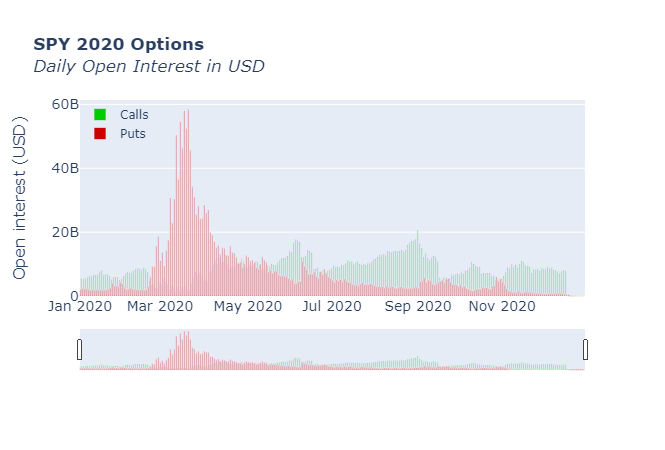

In [12]:
# create list of dates 
call_open_interest_by_day['quotedate'].dt.date
quotedate_list = call_open_interest_by_day['quotedate'].to_list()

# convert openinterest_$value into lists for calls and puts
call_open_interest_list = call_open_interest_by_day['openinterest_$value'].tolist()
put_open_interest_list = put_open_interest_by_day['openinterest_$value'].tolist()

# create volume chart by day
chart_open_interest_by_day = go.Figure()
chart_open_interest_by_day.add_trace(go.Bar(name='Calls',
                                     x=quotedate_list, 
                                     y=call_open_interest_list,
                                     marker_color='rgb(0,204,0)',
                                     text= call_open_interest_list, 
                                     texttemplate='%{text:.3s}', 
                                     textposition='outside'
                                    )
                                    )
chart_open_interest_by_day.add_trace(go.Bar(name='Puts',
                                     x=quotedate_list, 
                                     y=put_open_interest_list,
                                     marker_color='rgb(204,0,0)',
                                     text= put_open_interest_list, 
                                     texttemplate='%{text:.3s}', 
                                     textposition='outside')
                                    )
chart_open_interest_by_day.update_xaxes(rangeslider_visible=True,
                                 rangebreaks=[
                                     dict(bounds=["sat", "mon"]),
                                     dict(values=["2020-01-01",
                                                  "2020-01-20", 
                                                  "2020-02-17",
                                                  "2020-04-10",
                                                  "2020-05-25",
                                                  "2020-07-03", 
                                                  "2020-09-07", 
                                                  "2020-11-26", 
                                                  "2020-12-25"])]
                                       )
chart_open_interest_by_day.update_layout(title=f'<b>SPY 2020 Options</b><br><i>Daily Open Interest in USD</i>',
                                         xaxis_tickfont_size=14,
                                         yaxis=dict(
                                             title='Open interest (USD)',
                                             titlefont_size=16,
                                             tickfont_size=14,),
                                         legend=dict(
                                             x=0,
                                             y=1.0,
                                             bgcolor='rgba(255, 255, 255, 0)',
                                             bordercolor='rgba(255, 255, 255, 0)')
                                        )

# --VOLUME--
## Volume - Calls

In [13]:
# calculate options volume by day and groupby date and type
option_volume_by_day = df_stocks_and_options.groupby(['quotedate','type'])[['volume']].sum().reset_index()

# create call volumes df
call_volume_by_day = option_volume_by_day.loc[option_volume_by_day['type'] == 'call']
call_volume_by_day.reset_index(drop=True, inplace=True)
call_volume_by_day.head()

quotedate  type   volume
0 2020-01-02  call  1058845
1 2020-01-03  call  1234638
2 2020-01-06  call   945678
3 2020-01-07  call   870324
4 2020-01-08  call  1417889

## Volume - Puts

In [14]:
# create call volumes df
put_volume_by_day = option_volume_by_day.loc[option_volume_by_day['type'] == 'put']
put_volume_by_day.reset_index(drop=True, inplace=True)
put_volume_by_day.head()

quotedate type   volume
0 2020-01-02  put  1407619
1 2020-01-03  put  1937446
2 2020-01-06  put  1409353
3 2020-01-07  put   946351
4 2020-01-08  put  1647037

## Volume Bar Graph - Calls v. Puts

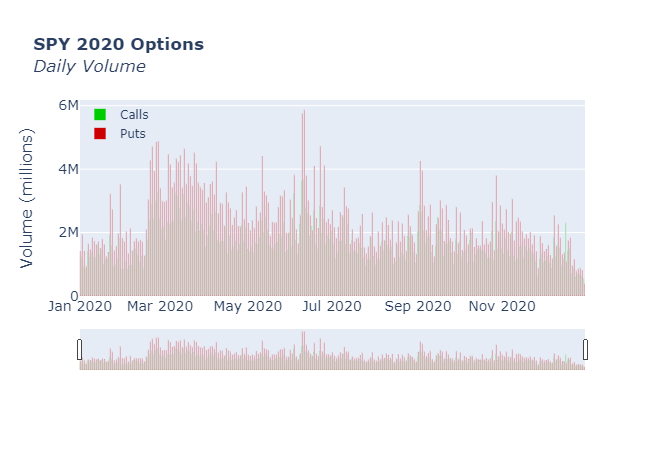

In [15]:
# create list of dates 
call_volume_by_day['quotedate'].dt.date
quotedate_list = call_volume_by_day['quotedate'].to_list()

# convert volume into lists for calls and puts
call_volume_list = call_volume_by_day['volume'].tolist()
put_volume_list = put_volume_by_day['volume'].tolist()

# create volume chart by day
chart_volume_by_day = go.Figure()
chart_volume_by_day.add_trace(go.Bar(name='Calls',
                                     x=quotedate_list, 
                                     y=call_volume_list,
                                     marker_color='rgb(0,204,0)',
                                     text= call_volume_list, 
                                     texttemplate='%{text:.3s}', 
                                     textposition='outside'
                                    )
                             )
chart_volume_by_day.add_trace(go.Bar(name='Puts',
                                     x=quotedate_list, 
                                     y=put_volume_list,
                                     marker_color='rgb(204,0,0)',
                                     text= put_volume_list, 
                                     texttemplate='%{text:.3s}', 
                                     textposition='outside')
                             )
chart_volume_by_day.update_xaxes(rangeslider_visible=True,
                                 rangebreaks=[
                                     dict(bounds=["sat", "mon"]),
                                     dict(values=["2020-01-01",
                                                  "2020-01-20", 
                                                  "2020-02-17",
                                                  "2020-04-10",
                                                  "2020-05-25",
                                                  "2020-07-03", 
                                                  "2020-09-07", 
                                                  "2020-11-26", 
                                                  "2020-12-25"])]
                                )
chart_volume_by_day.update_layout(title=f'<b>SPY 2020 Options</b><br><i>Daily Volume</i>',
                                  xaxis_tickfont_size=14,
                                  yaxis=dict(
                                      title='Volume (millions)',
                                      titlefont_size=16,
                                      tickfont_size=14,),
                                  legend=dict(
                                      x=0,
                                      y=1.0,
                                      bgcolor='rgba(255, 255, 255, 0)',
                                      bordercolor='rgba(255, 255, 255, 0)')
                                 )

# --CALL OPTIONS--
## Closing Prices - Top 3 Call Options (open interest)

In [16]:
# sort stocks and options data by open interest in descending order
sorted_df_stocks_and_options = df_stocks_and_options.sort_values(by='openinterest_$value', ascending=False)

# create new df to create call options df
df_call_only = sorted_df_stocks_and_options.loc[sorted_df_stocks_and_options['type'] == 'call']
df_call_only.reset_index(inplace=True)

# group puts by expiration date and sum open_interest_$value
df_call_by_exp_date = df_call_only.groupby(['expiration_date','strike','type'])[['openinterest_$value']].sum()
df_call_by_exp_date = df_call_by_exp_date.sort_values(by='openinterest_$value', ascending=False).reset_index()
df_call_by_exp_date.head(3)

expiration_date  strike  type  openinterest_$value
0      2020-12-18   315.0  call         3.305591e+10
1      2020-12-18   290.0  call         3.093919e+10
2      2020-12-18   310.0  call         3.035349e+10

## Closing Prices - 1st Call (open interest)

C:\Users\avile\anaconda3\envs\pyvizenv\lib\site-packages\pandas\core\frame.py:4025: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



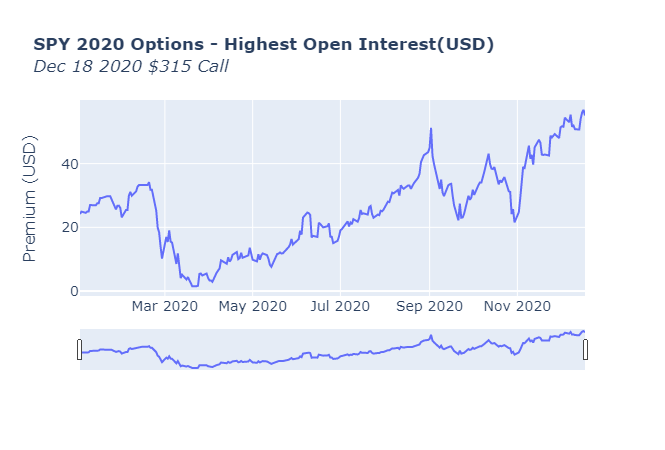

In [17]:
# create df for put option with 1st largest openinterest_$value
df_first_open_interest_call = df_call_only.loc[df_call_only['expiration_date'] == '2020-12-18']
df_first_open_interest_call = df_first_open_interest_call.loc[df_call_only['strike'] == 315.0]
df_first_open_interest_call = df_first_open_interest_call.sort_values('quotedate').reset_index(drop=True)

# slice data for closing prices of first option
first_open_interest_call_price = df_first_open_interest_call[['quotedate','last']]

# rename 'last' column to 'option_close' and set quotedate as index
first_open_interest_call_price.rename(columns = {'last':'option_close'}, inplace = True)
# first_open_interest_call_price.set_index(keys = "quotedate" , inplace = True)

# create list of dates 
first_open_interest_call_price['quotedate'].dt.date
first_call_quotedate_list = first_open_interest_call_price['quotedate'].to_list()

# convert closing price of first call into list
first_call_price_list = first_open_interest_call_price['option_close'].to_list()

# plot closing prices line chart
chart_first_open_interest_call = go.Figure()
chart_first_open_interest_call.add_trace(go.Scatter(x= first_call_quotedate_list,
                                                   y= first_call_price_list,
#                                                    mode='lines+markers',
                                                   name='Dec 18 2020 $315 Call')
                                       )
chart_first_open_interest_call.update_layout(title=f'<b>SPY 2020 Options - Highest Open Interest(USD)</b><br><i>Dec 18 2020 $315 Call</i>',
                                            xaxis_tickfont_size=14,
                                            yaxis=dict(
                                                title='Premium (USD)',
                                                titlefont_size=16,
                                                tickfont_size=14,),
                                            legend=dict(
                                                x=0,
                                                y=1.0,
                                                bgcolor='rgba(255, 255, 255, 0)',
                                                bordercolor='rgba(255, 255, 255, 0)')
                                           )
chart_first_open_interest_call.update_xaxes(rangeslider_visible=True)
chart_first_open_interest_call.show()

## Closing Prices - 2nd Call (open interest)

C:\Users\avile\anaconda3\envs\pyvizenv\lib\site-packages\pandas\core\frame.py:4025: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



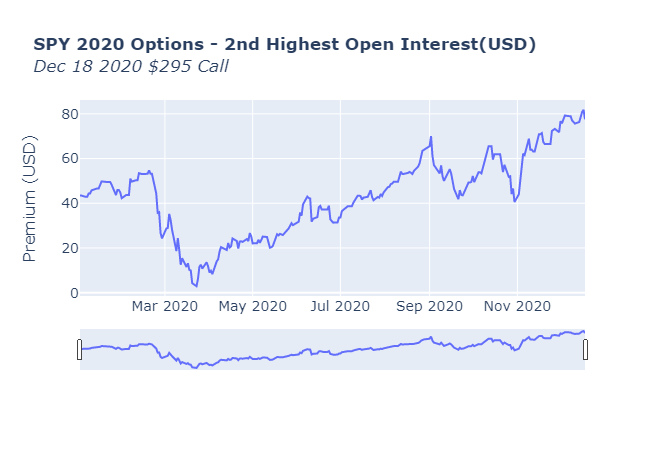

In [18]:
# create df for put option with 1st largest openinterest_$value
df_second_open_interest_call = df_call_only.loc[df_call_only['expiration_date'] == '2020-12-18']
df_second_open_interest_call = df_second_open_interest_call.loc[df_call_only['strike'] == 290.0]
df_second_open_interest_call = df_second_open_interest_call.sort_values('quotedate').reset_index(drop=True)

# slice data for closing prices of first option
second_open_interest_call_price = df_second_open_interest_call[['quotedate','last']]

# rename 'last' column to 'option_close' and set quotedate as index
second_open_interest_call_price.rename(columns = {'last':'option_close'}, inplace = True)
# first_open_interest_call_price.set_index(keys = "quotedate" , inplace = True)

# create list of dates 
second_open_interest_call_price['quotedate'].dt.date
second_call_quotedate_list = second_open_interest_call_price['quotedate'].to_list()

# convert closing price of first put into list
second_call_price_list = second_open_interest_call_price['option_close'].to_list()

# plot closing prices line chart
chart_second_open_interest_call = go.Figure()
chart_second_open_interest_call.add_trace(go.Scatter(x= second_call_quotedate_list,
                                                   y= second_call_price_list,
#                                                    mode='lines+markers',
                                                   name='Dec 18 2020 $295 Call')
                                       )
chart_second_open_interest_call.update_layout(title=f'<b>SPY 2020 Options - 2nd Highest Open Interest(USD)</b><br><i>Dec 18 2020 $295 Call</i>',
                                            xaxis_tickfont_size=14,
                                            yaxis=dict(
                                                title='Premium (USD)',
                                                titlefont_size=16,
                                                tickfont_size=14,),
                                            legend=dict(
                                                x=0,
                                                y=1.0,
                                                bgcolor='rgba(255, 255, 255, 0)',
                                                bordercolor='rgba(255, 255, 255, 0)')
                                           )
chart_second_open_interest_call.update_xaxes(rangeslider_visible=True)
chart_second_open_interest_call.show()

## Closing Prices - 3rd Call (open interest)

C:\Users\avile\anaconda3\envs\pyvizenv\lib\site-packages\pandas\core\frame.py:4025: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



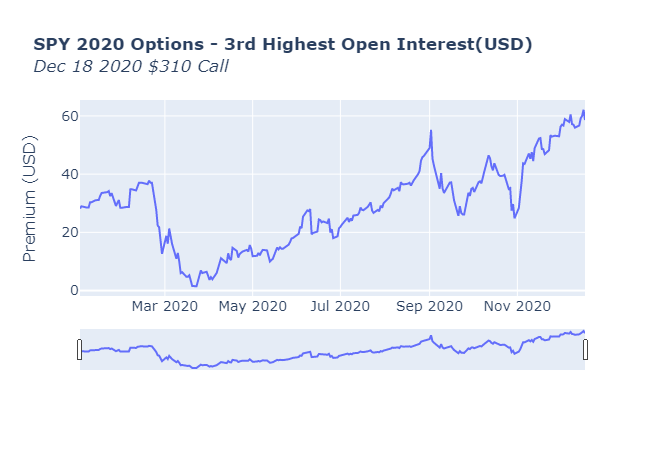

In [19]:
# create df for put option with 1st largest openinterest_$value
df_third_open_interest_call = df_call_only.loc[df_call_only['expiration_date'] == '2020-12-18']
df_third_open_interest_call = df_third_open_interest_call.loc[df_call_only['strike'] == 310.0]
df_third_open_interest_call = df_third_open_interest_call.sort_values('quotedate').reset_index(drop=True)

# slice data for closing prices of first option
third_open_interest_call_price = df_third_open_interest_call[['quotedate','last']]

# rename 'last' column to 'option_close' and set quotedate as index
third_open_interest_call_price.rename(columns = {'last':'option_close'}, inplace = True)
# first_open_interest_call_price.set_index(keys = "quotedate" , inplace = True)

# create list of dates 
third_open_interest_call_price['quotedate'].dt.date
third_call_quotedate_list = third_open_interest_call_price['quotedate'].to_list()

# convert closing price of first put into list
third_call_price_list = third_open_interest_call_price['option_close'].to_list()

# plot closing prices line chart
chart_third_open_interest_call = go.Figure()
chart_third_open_interest_call.add_trace(go.Scatter(x= third_call_quotedate_list,
                                                   y= third_call_price_list,
#                                                    mode='lines+markers',
                                                   name='Dec 18 2020 $310 Call')
                                       )
chart_third_open_interest_call.update_layout(title=f'<b>SPY 2020 Options - 3rd Highest Open Interest(USD)</b><br><i>Dec 18 2020 $310 Call</i>',
                                            xaxis_tickfont_size=14,
                                            yaxis=dict(
                                                title='Premium (USD)',
                                                titlefont_size=16,
                                                tickfont_size=14,),
                                            legend=dict(
                                                x=0,
                                                y=1.0,
                                                bgcolor='rgba(255, 255, 255, 0)',
                                                bordercolor='rgba(255, 255, 255, 0)')
                                           )
chart_third_open_interest_call.update_xaxes(rangeslider_visible=True)
chart_third_open_interest_call.show()

# --PUT OPTIONS--
## Closing Prices - Top 3 Put Options (open interest)

In [20]:
# slice data to create put options df
df_put_only = sorted_df_stocks_and_options.loc[sorted_df_stocks_and_options['type'] == 'put']
df_put_only.reset_index(inplace=True)

# group puts by expiration date
df_put_by_exp_date = df_put_only.groupby(['expiration_date','strike','type'])[['openinterest_$value']].sum()
df_put_by_exp_date = df_put_by_exp_date.sort_values(by='openinterest_$value', ascending=False).reset_index()
df_put_by_exp_date.head(3)

expiration_date  strike type  openinterest_$value
0      2020-09-18   295.0  put         3.220908e+10
1      2020-10-16   260.0  put         2.397588e+10
2      2020-06-19   280.0  put         2.086703e+10

## Closing Prices - 1st Put (open interest)

C:\Users\avile\anaconda3\envs\pyvizenv\lib\site-packages\pandas\core\frame.py:4025: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\avile\anaconda3\envs\pyvizenv\lib\site-packages\pandas\core\frame.py:4025: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



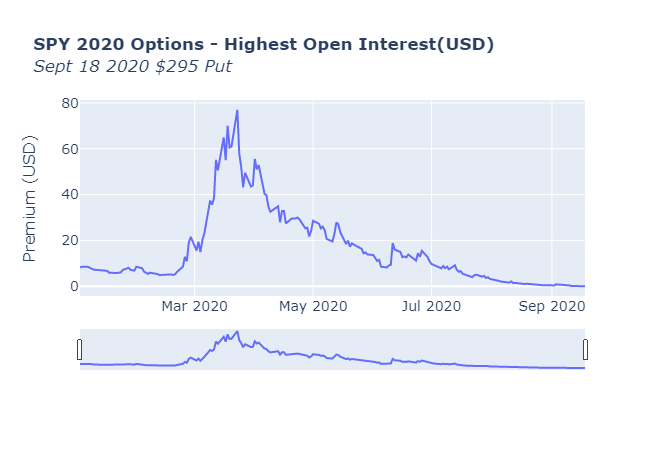

In [21]:
# create df for put option with 1st largest openinterest_$value
df_first_open_interest_put = df_put_only.loc[df_put_only['expiration_date'] == '2020-09-18']
df_first_open_interest_put = df_first_open_interest_put.loc[df_put_only['strike'] == 295.0]
df_first_open_interest_put = df_first_open_interest_put.sort_values('quotedate').reset_index(drop=True)

# create new df for closing prices of first option
first_open_interest_put_price = df_first_open_interest_put[['quotedate','last']]

# rename 'last' column to 'option_close' and set quotedate as index
first_open_interest_put_price.rename(columns = {'last':'option_close'}, inplace = True)
# first_open_interest_put_price.set_index(keys = "quotedate" , inplace = True)

# create df for put option with 1st largest openinterest_$value
df_first_open_interest_put = df_put_only.loc[df_put_only['expiration_date'] == '2020-09-18']
df_first_open_interest_put = df_first_open_interest_put.loc[df_put_only['strike'] == 295.0]
df_first_open_interest_put = df_first_open_interest_put.sort_values('quotedate').reset_index(drop=True)

# create new df for closing prices of first option
first_open_interest_put_price = df_first_open_interest_put[['quotedate','last']]

# rename 'last' column to 'option_close' and set quotedate as index
first_open_interest_put_price.rename(columns = {'last':'option_close'}, inplace = True)
# first_open_interest_put_price.set_index(keys = "quotedate" , inplace = True)

# create list of dates 
first_open_interest_put_price['quotedate'].dt.date
first_put_quotedate_list = first_open_interest_put_price['quotedate'].to_list()

# convert closing price of first put into list
first_put_price_list = first_open_interest_put_price['option_close'].to_list()

# plot closing prices line chart
chart_first_open_interest_put = go.Figure()
chart_first_open_interest_put.add_trace(go.Scatter(x= first_put_quotedate_list,
                                                   y= first_put_price_list,
#                                                    mode='lines+markers',
                                                   name='Sept 18 2020 $295 Put')
                                      )
chart_first_open_interest_put.update_layout(title='<b>SPY 2020 Options - Highest Open Interest(USD)</b><br><i>Sept 18 2020 $295 Put</i>',
                                            xaxis_tickfont_size=14,
                                            yaxis=dict(
                                                title='Premium (USD)',
                                                titlefont_size=16,
                                                tickfont_size=14,),
                                            legend=dict(
                                                x=0,
                                                y=1.0,
                                                bgcolor='rgba(255, 255, 255, 0)',
                                                bordercolor='rgba(255, 255, 255, 0)')
                                           )
chart_first_open_interest_put.update_xaxes(rangeslider_visible=True)
chart_first_open_interest_put.show()

## Closing Prices - 2nd Put (open interest)

C:\Users\avile\anaconda3\envs\pyvizenv\lib\site-packages\pandas\core\frame.py:4025: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



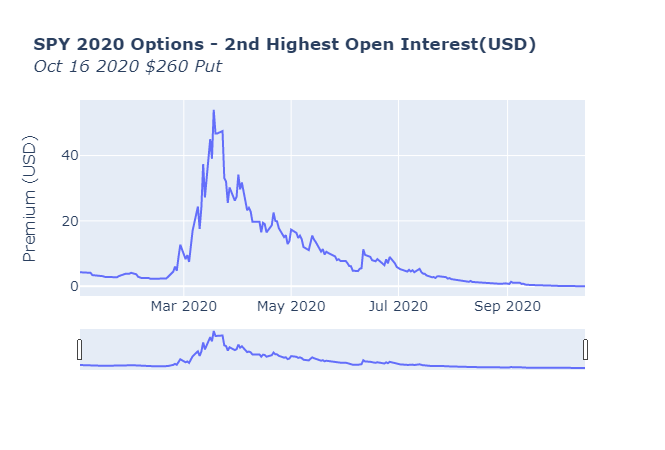

In [22]:
# create df for put option with 1st largest openinterest_$value
df_second_open_interest_put = df_put_only.loc[df_put_only['expiration_date'] == '2020-10-16']
df_second_open_interest_put = df_second_open_interest_put.loc[df_put_only['strike'] == 260.0]
df_second_open_interest_put = df_second_open_interest_put.sort_values('quotedate').reset_index(drop=True)

# create new df for closing prices of first option
second_open_interest_put_price = df_second_open_interest_put[['quotedate','last']]

# rename 'last' column to 'option_close' and set quotedate as index
second_open_interest_put_price.rename(columns = {'last':'option_close'}, inplace = True)
# first_open_interest_put_price.set_index(keys = "quotedate" , inplace = True)

# create list of dates 
second_open_interest_put_price['quotedate'].dt.date
second_put_quotedate_list = second_open_interest_put_price['quotedate'].to_list()

# convert closing price of first put into list
second_put_price_list = second_open_interest_put_price['option_close'].to_list()

# plot closing prices line chart
chart_second_open_interest_put = go.Figure()
chart_second_open_interest_put.add_trace(go.Scatter(x= second_put_quotedate_list,
                                                   y= second_put_price_list,
#                                                    mode='lines+markers',
                                                   name='Oct 16 2020 $260 Put')
                                       )
chart_second_open_interest_put.update_layout(title='<b>SPY 2020 Options - 2nd Highest Open Interest(USD)</b><br><i>Oct 16 2020 $260 Put</i>',
                                            xaxis_tickfont_size=14,
                                            yaxis=dict(
                                                title='Premium (USD)',
                                                titlefont_size=16,
                                                tickfont_size=14,),
                                            legend=dict(
                                                x=0,
                                                y=1.0,
                                                bgcolor='rgba(255, 255, 255, 0)',
                                                bordercolor='rgba(255, 255, 255, 0)')
                                           )
chart_second_open_interest_put.update_xaxes(rangeslider_visible=True)
chart_second_open_interest_put.show()

## Closing Prices - 3rd Put (open interest)

C:\Users\avile\anaconda3\envs\pyvizenv\lib\site-packages\pandas\core\frame.py:4025: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



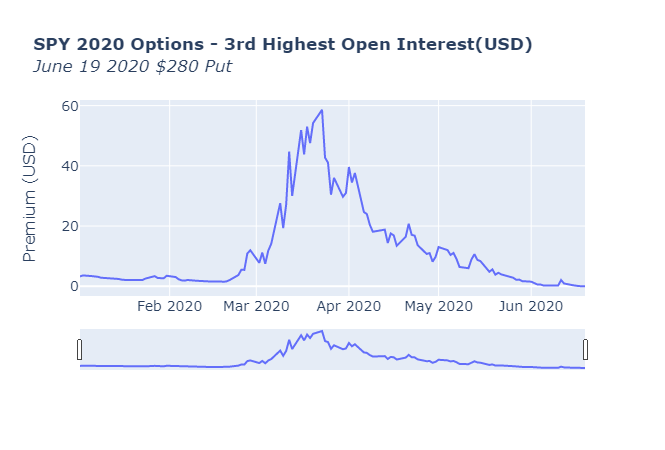

In [24]:
# create df for put option with 1st largest openinterest_$value
df_third_open_interest_put = df_put_only.loc[df_put_only['expiration_date'] == '2020-06-19']
df_third_open_interest_put = df_third_open_interest_put.loc[df_put_only['strike'] == 280.0]
df_third_open_interest_put = df_third_open_interest_put.sort_values('quotedate').reset_index(drop=True)

# create new df for closing prices of first option
third_open_interest_put_price = df_third_open_interest_put[['quotedate','last']]

# rename 'last' column to 'option_close' and set quotedate as index
third_open_interest_put_price.rename(columns = {'last':'option_close'}, inplace = True)
# first_open_interest_put_price.set_index(keys = "quotedate" , inplace = True)

# create list of dates 
third_open_interest_put_price['quotedate'].dt.date
third_put_quotedate_list = third_open_interest_put_price['quotedate'].to_list()

# convert closing price of first put into list
third_put_price_list = third_open_interest_put_price['option_close'].to_list()

# plot closing prices line chart
chart_third_open_interest_put = go.Figure()
chart_third_open_interest_put.add_trace(go.Scatter(x= third_put_quotedate_list,
                                                   y= third_put_price_list,
#                                                    mode='lines+markers',
                                                   name='June 19 2020 $280 Put')
                                       )
chart_third_open_interest_put.update_layout(title='<b>SPY 2020 Options - 3rd Highest Open Interest(USD)</b><br><i>June 19 2020 $280 Put</i>',
                                            xaxis_tickfont_size=14,
                                            yaxis=dict(
                                                title='Premium (USD)',
                                                titlefont_size=16,
                                                tickfont_size=14,),
                                            legend=dict(
                                                x=0,
                                                y=1.0,
                                                bgcolor='rgba(255, 255, 255, 0)',
                                                bordercolor='rgba(255, 255, 255, 0)')
                                           )
chart_third_open_interest_put.update_xaxes(rangeslider_visible=True)
chart_third_open_interest_put.show()